<a href="https://colab.research.google.com/github/chidcrushev/KmeansClustering-MapReduce/blob/master/Kmeans_MapReduce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#Install the dependencies (Apache Spark 3.0-Hadoop 2.7, Java 8, and FindSpark) in Colab environment:
!rm -r spark*
!apt-get install openjdk-8-jdk-headless -qq
!wget -q http://mirrors.koehn.com/apache/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
!tar xf spark-3.0.0-preview2-bin-hadoop3.2.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"

import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark
sc= spark.sparkContext.getOrCreate()

rm: cannot remove 'spark*': No such file or directory


In [0]:
dataSet = spark.read.csv("s3.csv", inferSchema=True)
dataSet_rename = dataSet.withColumnRenamed("_c0","x") \
    .withColumnRenamed("_c1","y")
dataSet_rename.show(5,True)

+------+------+
|     x|     y|
+------+------+
|453320|606542|
|520651|594591|
|516664|660290|
|570023|570741|
|524035|518443|
+------+------+
only showing top 5 rows



In [0]:
from scipy.spatial import distance
import numpy as np
data_array =  np.array(dataSet_rename.select("x", "y").collect())
print (len(data_array))
flag = True ;

5000


In [0]:
#Calculates the Straight line distance between two points
from scipy.spatial import distance
def calculate_distance(x,y):
 return distance.euclidean(x,y);

In [0]:
#MapReduce function for K-means clustering
def mapperReducer(data, centroidPoints):
 mappedData = data.rdd.map(lambda x: ([calculate_distance(x, centroidPoints[i]) for i in range(k)], x)).map(lambda x : (x[0].index(min(x[0])), (x[1],1)))
 reducedData= mappedData.reduceByKey(lambda x, y: ((x[0][0]+y[0][0],x[0][1]+y[0][1] ), x[1]+y[1]));
 meanXY = reducedData.map(lambda x: (x[0], (x[1][0][0]/x[1][1], x[1][0][1]/x[1][1])));
 sort_meanXY = meanXY.sortByKey(ascending=True).values().collect();
 return (sort_meanXY);

In [0]:
#Finds the new centroids
def findNewCentroids(data):
  newCentroidPoints= [];
  for i in data:
    newCentroidPoints.append([i[0],i[1]]);
  return newCentroidPoints;  

In [0]:
#To form random centroids for the first iteration.
vectors = [np.array(point) for point in data_array]
parallelVectors = sc.parallelize(vectors)
parallelVectors.cache()
k =15 #Number of clusters
# You can set the iteration
iteration = 30;
centroidPoints =parallelVectors.takeSample(False, k)
print (centroidPoints)

[array([273073, 299054]), array([565545, 431355]), array([447666, 300851]), array([304166, 469615]), array([301688, 467763]), array([151930, 205100]), array([286646, 802691]), array([381722, 526403]), array([544674, 607976]), array([368612, 331490]), array([631955, 390694]), array([505993, 602027]), array([328889, 352611]), array([436605, 281804]), array([586777, 717506])]


In [0]:
# Iteration for K-means CLustering
for i in range(iteration):
 mappedData = mapperReducer(dataSet_rename, centroidPoints);
 centroidPoints = [];
 centroidPoints = findNewCentroids(mappedData);
 print ("New Centroids after iteration",i+1,":" ,centroidPoints)
  

New Centroids after iteration 1 : [[241913.9090909091, 303679.4946524064], [546563.4849246232, 436969.7336683417], [497758.3046875, 326033.421875], [313341.14285714284, 481267.1836734694], [284779.84897959186, 454405.89795918367], [178557.12541254127, 210788.39603960395], [337477.6695156695, 766566.339031339], [369265.61875, 562119.45625], [577861.4680851063, 596845.0212765958], [391862.665, 340583.71], [714197.5545796738, 357742.8494353827], [485679.80733944953, 609635.4266055046], [318129.2156862745, 369776.1568627451], [436031.20089285716, 224528.92857142858], [709737.8174358974, 742266.5774358974]]
New Centroids after iteration 2 : [[231646.14110429448, 317739.5736196319], [551694.1066350711, 441302.41706161137], [528862.7394136807, 312984.664495114], [317135.2751091703, 476888.0829694323], [278508.93296089384, 449313.8100558659], [187613.17791411042, 207138.92331288345], [341606.85635359114, 766153.3591160221], [358423.0408921933, 587020.624535316], [599237.44, 606798.9485714285],

In [0]:
#Cluster assignment to each data point after "n" number of iteration
clusterAssigment = clusterAssigment1= dataSet_rename.rdd.map(lambda x: ([calculate_distance(x, centroidPoints[i]) for i in range(k)], x)).map(lambda x : (x[0].index(min(x[0])), x[1]));
clusterAssigment.take(5)
clusterAssigment.saveAsTextFile("resultsClusterAssignment.csv")
#Now refresh. You will see the csv file in the files section in the left side of the window.

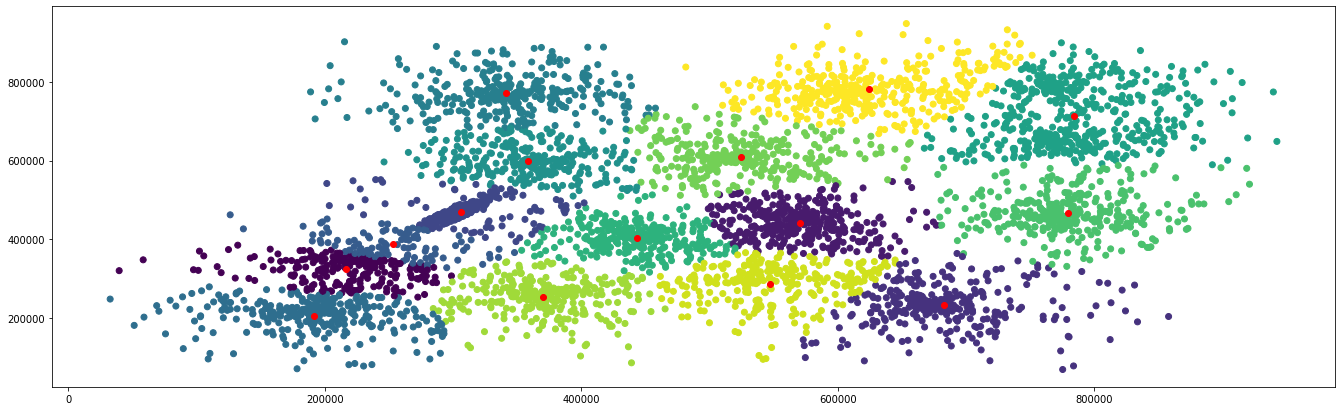

In [0]:
#Scatter plot - Run this to generate scatter plot
data = np.array(clusterAssigment.map(lambda x: x[1]).collect());
clusters = np.array(clusterAssigment1.map(lambda x: x[0]).collect());
import matplotlib.pyplot as plt
plt.figure(figsize=(23,7))
plt.scatter(data[:,0],data[:,1], c=clusters)
for i in range(k):
 plt.scatter(centroidPoints[i][0] ,centroidPoints[i][1], color='red')
